# Dask and XGBoost

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" align="left" width="30%" alt="Dask logo">

<img src="https://raw.githubusercontent.com/dmlc/dmlc.github.io/master/img/logo-m/xgboost.png" align="left" width="25%" alt="Dask logo">

In [1]:
%matplotlib inline

The `dask-xgboost` library provides a small wrapper around `dask-xgboost` for passing dask objects to `xgboost`.

As usual, we can create or attach to our cluster by creating a `Client`

In [2]:
import os
from dask import compute, persist
from dask.distributed import Client, progress

client = Client(os.environ.get("DISTRIBUTED_ADDRESS"))  # connect to cluster 

We'll work through an example using the airlines dataset.
For a recorded screen cast, see [here](https://www.youtube.com/watch?v=Cc4E-PdDSro).
Our task is to pick whether or not a flight was delayed for more than 15 minutes.

First, let's load the data.

In [3]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
df = dd.read_csv('s3://dask-data/airline-data/2006.csv', usecols=cols,
                 storage_options={'anon': True})

frac = 0.01
df = df.sample(frac=frac) # we blow out ram otherwise

is_delayed = (df.DepDelay.fillna(16) > 15)

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
del df['DepDelay']

df, is_delayed = persist(df, is_delayed)
progress(df, is_delayed)

In [6]:
df.head()

,Year,Month,DayOfWeek,CRSDepTime,UniqueCarrier,Origin,Dest,Distance
156561,2006,1,2,1440,OH,CVG,MHT,741
359225,2006,1,5,1241,MQ,DFW,CLE,1021
414374,2006,1,6,1031,NW,MBS,DTW,98
39002,2006,1,3,725,WN,CRP,HOU,187
488494,2006,1,3,1259,AA,DFW,BDL,1471


In [7]:
is_delayed.head()

156561    False
359225    False
414374    False
39002     False
488494    False
Name: DepDelay, dtype: bool

In [8]:
df2 = dd.get_dummies(df.categorize()).persist()

## Split and Train

We'll split the original dataset into train and test sets.
The model will be fit on `data_train` and evaluated on `data_test`.

In [9]:
data_train, data_test = df2.random_split([0.9, 0.1], 
                                         random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], 
                                                    random_state=1234)

Now we can fit the model. This is exactly like normal, except you'll import `dask_xgboost`.
It will take care of handing the data off to the distributed `xgboost` processes, and from there everything proceeds as normal.

In [10]:
%%time
import dask_xgboost as dxgb
import xgboost as xgb

params = {'objective': 'binary:logistic', 'nround': 1000, 
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 1}

bst = dxgb.train(client, params, data_train, labels_train)
bst

CPU times: user 962 ms, sys: 569 ms, total: 1.53 s
Wall time: 17.2 s


The `bst` object is just a reguler `xgboost.Booster`, so all the familar methods are available.

In [11]:
import matplotlib.pyplot as plt

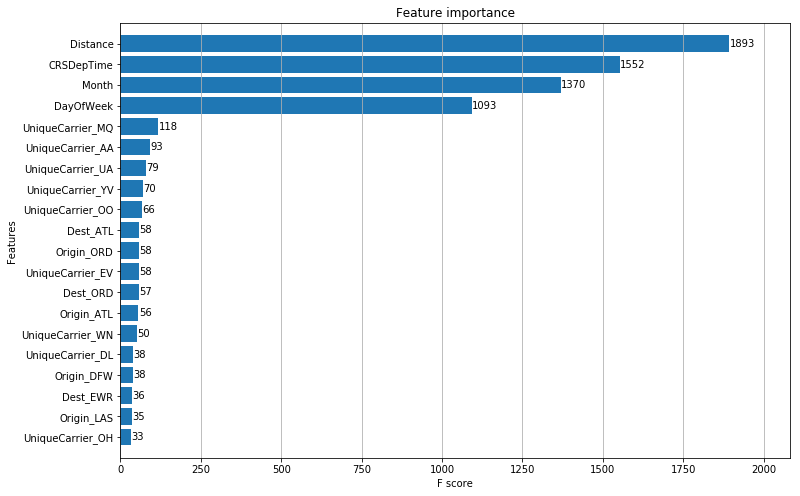

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=20)
ax.grid("off", axis="y")

Let's get the predictions. The is the same as usual, except we're using `dxgb`.

In [13]:
predictions = dxgb.predict(client, bst, data_test)
predictions = client.persist(predictions)
predictions

Dask Series Structure:
npartitions=11
None    float32
None        ...
         ...   
None        ...
None        ...
Name: predictions, dtype: float32
Dask Name: _predict_part, 11 tasks

The `predictions` object is a `dask.Series`, so it can be used in place of a numpy array in most places.

In [14]:
from sklearn.metrics import roc_curve, auc

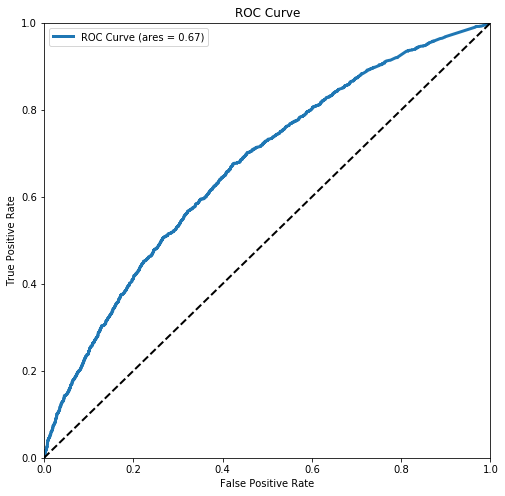

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
fpr, tpr, _ = roc_curve(labels_test, predictions)
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (ares = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)

ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();